# 4. Dimensionality reduction

Dimensionality reduction is a useful tool in several scenarios.
If you're working with highly-dimensional data, feature selection can help you choose the most salient features.
And if you want to lose less information, you can use feature extraction to combine the most important features into new variables.

A lot of the functionality related with dimensionality reduction is in scikit-learn, but we'll still need pandas.
We'll also use matplotlib later to visualize decision trees.
We load the basic libraries first.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Feature selection

For feature selection, we will use the Titanic dataset, which we load next into a pandas DataFrame.

In [2]:
df = pd.read_csv('data/titanic-train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Variable encoding and imputation

For feature selection, we will use mutual information.
scikit-learn's implementation of mutual information expects only continuous variables, which means that we must encode non-numeric fields and handle missing values.

In this example, we'll ignore the `PassengerId` (since it's unique) and the `Name` (which we assume won't help us predict whether a passenger survived).
We also ignore the `Ticket` and `Cabin` features to simplify the problem.
That leaves us with two variables to encode: `Embarked` and `Sex`.

The next table shows us that we have 2 missing values in the `Embarked` column and quite a few in the `Age` feature.

In [3]:
_df = df.copy() # create a copy of the dataframe so we don't overwrite the original data
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Since we have 891 rows and we only have missing information for 2 passengers, we can safely remove those two rows.
Then, we encode the `Embarked` column using One-Hot Encoding.
Remember that One-Hot Encoding creates one column for each different value in the `Embarked` column (`S`, `C` and `Q`).

In [4]:
_df = _df.dropna(subset=[ 'Embarked' ]) # the one-hot encoder does not accept missing values, but we only have two of those

from sklearn import preprocessing # we'll use the preprocessing module for variable encoding

one_hot_encoder = preprocessing.OneHotEncoder(sparse=False) # create the one-hot encoder
encoding = one_hot_encoder.fit_transform(_df[[ 'Embarked' ]]) # encode the `Embarked` feature

_df[[ 'Embarked_C', 'Embarked_Q', 'Embarked_S' ]] = encoding # store the encoded `Embarked` values in new columns 
_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0


Encoding the `Sex` feature is simpler because the column only has two values: `male` and `female`.
We can use the `LabelEncoder` or the `OrdinalEncoder`.

In [5]:
label_encoder = preprocessing.LabelEncoder() # create the label encoder

encoding = label_encoder.fit_transform(_df.Sex) # encode the `Sex` feature

_df.Sex = encoding # replace the encoded `Sex` values
print(f"{ [ 0, 1 ] } are { list(label_encoder.inverse_transform([ 0, 1 ])) }")
_df.head()

[0, 1] are ['female', 'male']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0


There is just one thing left to do: dealing with the missing values of the `Age` feature.
Otherwise, mutual information refuses to work.
There are various ways of imputing the `Age`'s missing values, but we take a very simple approach: we use pandas' `fillna` method to fill the missing values with the mean.

In [6]:
_df.Age = _df.Age.fillna(_df.Age.mean()) # fill the Age's missing values with the mean

### Feature selection

Now, finally, we can look for the most important features.
Like most other operations, feature selection on scikit-learn consists of a few simple steps.
Naturally, first we need to import the module containing the feature selection functionality.

Unlike for encoding or machine learning algorithms, we don't need to instantiate the mutual information.
Instead, we can call the [`mutual_info_classif` method](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html).

> Note: The function name is `mutual_info_classif`, which stands for "mutual information for classification tasks".
  It is **not** a classifier.

We pass on three hyper-parameters to the `mutual_info_classif`:

- The subset of the data that we want to evaluate.
  We're not interested in the `PassengerId` or `Name`, and we want to use the features we just encoded.
  This is how we instruct the function to consider only a few variables.
- The label against which we want to calculate mutual information.
- The number of neighbors to consider when calculating mutual information, `n_neighbors`.
  
> Why neighbors?
  The implementation is based on the k-Nearest Neighbors (kNN) algorithm to calculate entropy since we have continous variables.
  Using more neighbors makes the results more reliable, but introduces some bias.

In [7]:
from sklearn import feature_selection # import the feature selection module

# specify what features we are interested in
features = [ 'Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked_S', 'Embarked_C', 'Embarked_Q']

# calculate mutual information
mi = feature_selection.mutual_info_classif(_df[ features ], # choose the columns we're interested in
                                           _df.Survived, # specify the label, `Survived`
                                           n_neighbors=50) # choose the number of neighbors to use for kNN

Now the results are in the variable `mi`.
Which features are the most important according to mutual information?
See the next code cell for the answer.
Are the results what you expected?

In [8]:
# create a dictionary with the features as keys and their mutual information with the label as values
mi = dict(zip(features, mi))

# sort the features in descending order of mutual information
important_features = sorted(mi, key=mi.get, reverse=True)

for feature in important_features:
    print(f"{ feature }: { mi[feature] }")

Sex: 0.14431576974173943
Fare: 0.06567925651230322
Pclass: 0.048000716038953506
SibSp: 0.013242222642170454
Embarked_C: 0.009695577243588716
Parch: 0.00846036123717031
Embarked_S: 0.007488247047261254
Age: 0.005878646736722004
Embarked_Q: 0.0


It's pretty clear that `Sex` is very helpful to decide whether a passenger survived.
`Age` is not, probably because there were other, more important factors that determined whether a passenger survived, such as their passenger class and gender.

Now we get to decide which features we want to keep.

In [9]:
keep = [ feature for feature, information in mi.items()
                 if information > 0.015 ] # keep features with a mutual information of at least 0.015
keep

['Fare', 'Pclass', 'Sex']

### Classification using feature selection

Now that we have gone to the trouble of choosing features, we can train an algorithm that uses only the,.
We fit a decision tree over this data using the [`DecisionTreeClassifier` class](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).
As usual, there are three steps:

1. Importing the module
2. Instantiating the classifier with hyper-parameters
3. Fitting the tree over our data, and optionally making predictions

When creating the classifier, we specify `max_leaf_nodes=5`.
In other words, the decision tree should only retain the 5-best leaves that it encounters first.
The `max_leaf_nodes` hyperparameter is a way of pruning trees to avoid overfitting.

In [10]:
from sklearn import tree # import the tree module

dt = tree.DecisionTreeClassifier(max_leaf_nodes=5) # create the DecisionTreeClassifier

X = _df[ keep ] # the training data is made up of the features that we want to keep
y = _df.Survived # the labels, or the `Survived` column
dt = dt.fit(X, y) # train, or fit, the decision tree

The easiest way to understand how the decision tree learned or fitted itself over our data is through visualizations.
We can visualize the tree using the `tree.plot_tree` method, which uses matplotlib.
When drawing the tree, we pass the following parameters:

- The model we trained earlier, `dt`, obviously
- The feature names; otherwise, the visualization will show `X[0]`, `X[1]` and so on
- The labels we want to show in the leaves

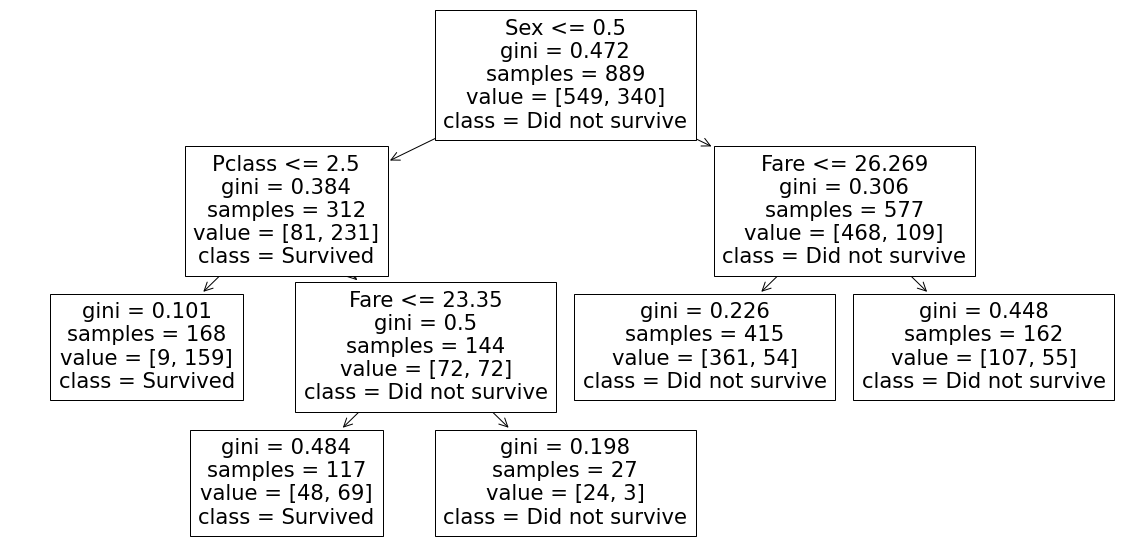

In [11]:
plt.figure(figsize=(20, 10)) # create a figure with a size of 20x10
tree.plot_tree(dt, feature_names=keep, class_names=[ 'Did not survive', 'Survived' ]) # plot the tree
plt.show() # ... and display it

What does the above tree tell us?
From top to bottom, each line in the node tells us:

- The condition, which appears always except in leaf nodes
- The number of `samples`, or examples, that go into that node
- The `value`, or how many passengers `Did not survive` and `Survived` in that node
- The `gini` coefficient: the higher it is, the more balanced the samples are
- The majority `class`, or the most common class of the examples in that node

For example, the top-most node tells us:

- The condition is `Sex <= 0.5`: is the `Sex` of the passenger `Female`? If it is, go left
- There are `889` samples, or all passengers in the beginning
- The `value` tells us that out of 889 passengers, 549 did not survive and 340 survived
- The `class` is `Did not survive` since more passengers (549) did not survive
- The `gini` coefficient is relatively high (0.472) because 549 and 340 are also relatively close to each other (around a 60/40 split)

## Feature extraction

For feature extraction, we'll use a different dataset: the Iris dataset.
This dataset contains 150 irises separated into three classes of 50 examples each.
Each observation has 4 features.

In [12]:
from sklearn import datasets # import the datasets module from scikit-learn
X, y = datasets.load_iris(return_X_y=True) # import the Iris dataset: the features (`X`) and the labels (`y`)
X.shape # (150 rows, 4 columns)

(150, 4)

If we plot the 3 classes with any 2 features, we can already observe that they are well-separated.
Only the orange and green classes have some overlap.
Experiment with different dimensions to see how the plot changes.

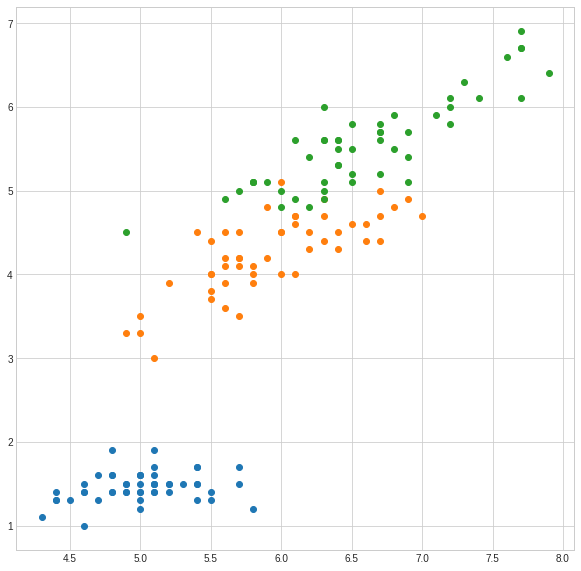

In [13]:
plt.style.use('seaborn-whitegrid') # change the style because no one likes an ugly visualization
plt.figure(figsize=(10, 10)) # create a figure with a custom size

# draw the classes separately (so they have different colors)
for i in range(3):
    class_i = [ _y == i for _y in y ] # choose the flowers that have class i
    plt.scatter(X[class_i, 0], X[class_i, 2]) # plot dimensions 0 and 2 of every iris with class i

plt.show() # show the plot

Could we train a good classifier with just 2 features instead of 4?
But how do we choose which features to keep?
Choosing them manually might introduce bias, and feature selection would still give us some overlapping classes.
So we experiment with feature extraction and PCA instead.

Fitting PCA is very easy, as usual, and we need to perform three steps:

1. Import the module containing PCA
2. Instantiate the [`PCA` class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
3. Fit the PCA model over our data

In [14]:
from sklearn import decomposition # import the decomposition module, which contains the PCA class

pca = decomposition.PCA() # instantiate the PCA class

components = pca.fit_transform(X) # fit PCA over the words and transform each flower to use the new components

The next row shows how much variance each new component (dimension) explains.
Remarkably, the first dimension describes 92% of all variation!
The ratios sum up to 100%.

In [15]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

If we plot the first dimension, the one with that explains the most variance in our data, it's clear just how well it describes the classes.

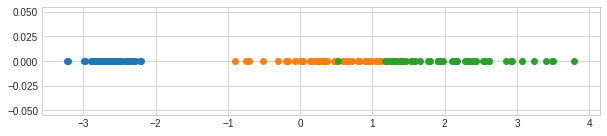

In [16]:
plt.style.use('seaborn-whitegrid') # change the style because no one likes an ugly visualization
plt.figure(figsize=(10, 2)) # create a figure with a custom size

# draw the classes separately (so they have different colors)
for i in range(3):
    class_i = [ _y == i for _y in y ] # choose the flowers that have class i
    plt.scatter(components[class_i, 0], [ 0 ] * sum(class_i)) # plot the top dimension (the y-coordinates are a constant)
plt.show() # show the plot

There is, of course, still some overlap between the orange and green classes.
Adding a second dimension separates the groups far better.

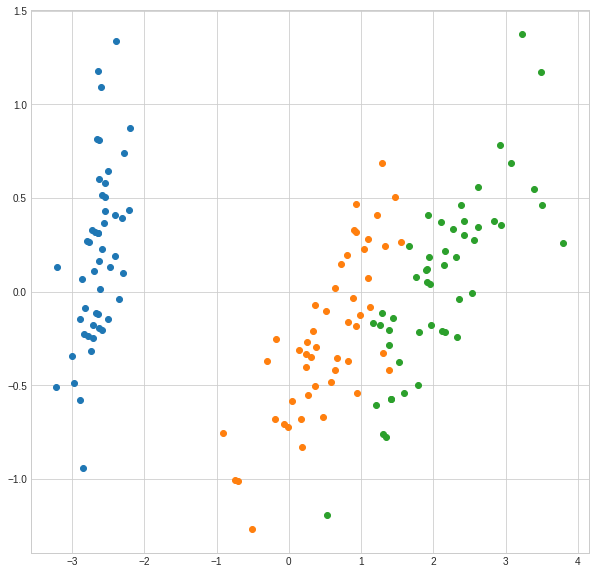

In [17]:
plt.style.use('seaborn-whitegrid') # change the style because no one likes an ugly visualization
plt.figure(figsize=(10, 10)) # create a figure with a custom size

# draw the classes separately (so they have different colors)
for i in range(3):
    class_i = [ _y == i for _y in y ] # choose the flowers that have class i
    plt.scatter(components[class_i, 0], components[class_i, 1]) # plot the top 2 dimensions
plt.show() # show the plot

## Exercise: dimensionality reduction for natural language processing

For this exercise, we'll use a more complex dataset: the [email spam classification dataset](https://www.kaggle.com/balaka18/email-spam-classification-dataset-csv).
This dataset has already been pre-processed, which greatly speeds up our process.

The next code cell loads the emails into a DataFrame.
Each email has 3002 columns: the first one, `Email No.`, is a unique identifier and the last one is the `Prediction`, indicating whether it is spam (1) or not (0).
The rest of the features represent words, and the column values are the number of times that a word appears in each email.

In [18]:
df = pd.read_csv('data/emails.csv') # read the emails dataset
df.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


Feature selection or feature extraction?
The answer depends a lot on what you want to get out of your data.
Do you want to retain human-readable features, or is performance more important?